In [2]:
from sklearn import linear_model
import sklearn.metrics 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import BernoulliRBM
from sklearn import decomposition 
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import numpy as np
import argparse
import stan
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
cd /Users/eth-may/Desktop/dtu/semester4/special course/

/Users/eth-may/Desktop/dtu/semester4/special course


In [4]:
#Load data
x_train = np.load("data/subset/genotyping_data_subset_train.cm.npy").T
y_train = np.load("data/train_heights.npy").reshape(-1,1)
x_test = np.load("data/subset/genotyping_data_subset_test.cm.npy").T
y_test = np.loadtxt('data/test_set_details_SECRET.txt', skiprows=1, dtype=float,usecols=(0), unpack=True).reshape(-1,1)
#Replace nan values in the training and testing set with an arbitrary number
#inds = np.where(np.isnan(x_train))
ytest=np.ravel(y_test)
ytrain=np.ravel(y_train)
x_all = np.append(x_train, x_test, axis = 0)
y_all = np.append(ytrain, ytest, axis = 0)
#x_train[inds] = -100
#inds = np.where(np.isnan(x_test))
#x_test[inds] = -100


In [5]:
class embedded:
    def __init__(self):
        super(embedded, self).__init__()
    
    def origial(self,x):
        return x

    def gender(self,x):
    # 0: female, 1:male
        gen = []
        for i in range(len(x)):
            if len(set(x[i][-687:]))==1:
                gen.append(0)
            else:
                gen.append(1) 
        return np.array(gen).reshape(-1, 1)
    
    def pca(self,x):
        pca=decomposition.PCA(n_components=40)
        reduced_x = pca.fit_transform(x)
        return reduced_x
    
    def nmf(self,x):
        nmf = decomposition.NMF(n_components=200, init='nndsvda', tol=5e-3)
        reduced_x = nmf.fit_transform(np.c_[x[:,:-687],self.gender(x)])
        return reduced_x
        
        
    def emb(self,x):  
        gen = self.gender(x)
        pcs = self.pca(x)
        data = np.c_[pcs,gen]
        return data
        
    def emb_x(self,x):  
        gen = self.gender(x)
        data = np.c_[x,gen]
        return data 
        
sim_lm = linear_model.LinearRegression()
lasso = linear_model.Lasso(alpha=0.7)
Baye_R = linear_model.BayesianRidge(compute_score=True, n_iter=3000)
reg_MLP = MLPRegressor(random_state=1, max_iter=500)

class model:
    def __init__(self,mode):
        super(model, self).__init__()
        self.regr = mode
        
    def pred(self,x,y,xt):
        # Predict the heights for the test set
        self.regr.fit(x, y)
        y_pred = self.regr.predict(xt)
        return y_pred
        
    def metrics(self,x,y,xt,yt):
        y_pred = self.pred(x,y,xt)
        #mse = mean_squared_error(yt, y_pred)
        r2 = r2_score(yt, y_pred)
        exVar = explained_variance_score(yt, y_pred)
    
        return ['r2,exVar:', r2, exVar]



In [6]:
#print(embedded().emb_x(x_all))

In [12]:
#Experiment for gender add x data
NUM_TRIALS = 30
nested_scores = np.zeros(NUM_TRIALS)
models = [sim_lm,lasso,Baye_R]

evas=[]
data = embedded()
emedding = [data.origial,data.emb_x,data.gender,data.emb,data.pca]

    
for j in emedding:
    
    eva=[]
    for i in models:
        xtrain = j(x_train)
        xtest = j(x_test)
        x = j(x_all)
        y = y_all
        model1 = model(i)
        
        scores = cross_val_score(i, x, y, scoring='explained_variance', cv=5)
        #print(scores.mean())
        #print(model(i).metrics(xtrain,ytrain,xtest,ytest)[1:])
        
        eva.append(scores.mean())
    #print(eva)
        
    evas.append(eva)


evas= np.array(evas)


In [8]:
#sklearn.metrics.SCORERS.keys()

In [13]:
evas

array([[0.33143588, 0.42653469, 0.40945565],
       [0.33163738, 0.42653469, 0.40968443],
       [0.36331596, 0.34532217, 0.36332354],
       [0.35531742, 0.35570768, 0.35027852],
       [0.34322998, 0.34915489, 0.35341754]])

<function matplotlib.pyplot.show(close=None, block=None)>

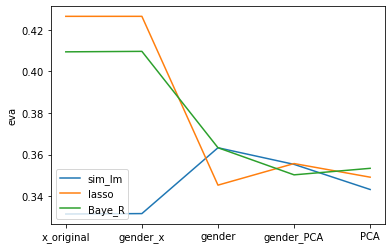

In [14]:
embed_way = ['x_original','gender_x','gender','gender_PCA', 'PCA']
legends=['sim_lm','lasso','Baye_R']
plt.figure()
for i in range(3):
    plt.plot(embed_way,evas[:,i],label=legends[i])
plt.legend(loc=3)
plt.ylabel("eva")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

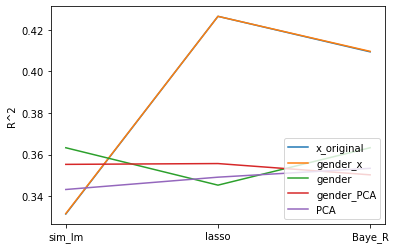

In [15]:
legends=['x_original','gender_x','gender','gender_PCA', 'PCA']
models=['sim_lm','lasso','Baye_R']
plt.figure()
for i in range(5):
    plt.plot(models,evas[i,:],label=legends[i])
plt.legend(loc=4)
plt.ylabel("R^2")
plt.show

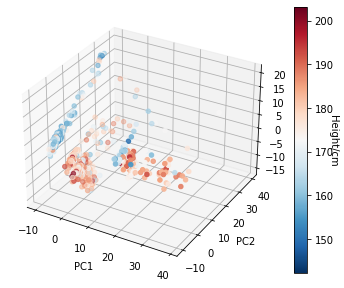

In [47]:

f_position=np.where(data.gender(x_train)==0)
m_position=np.where(data.gender(x_train)==1)
pcs = data.pca(x_train)
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter3D(pcs[f_position,0],pcs[f_position,1],pcs[f_position,2],cmap='Greens',label='female')
#ax.scatter3D(pcs[m_position,0],pcs[m_position,1],pcs[m_position,2],cmap='Blues',label='male')
color_map = plt.get_cmap('RdBu_r')
scatter_plot =ax.scatter3D(pcs[:,0],pcs[:,1],pcs[:,2],c=ytrain,cmap = color_map)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3',rotation=90)
#ax.set_clabel('Height')
cbar=plt.colorbar(scatter_plot)
cbar.set_label('Height/cm', rotation=270)
plt.tight_layout() 





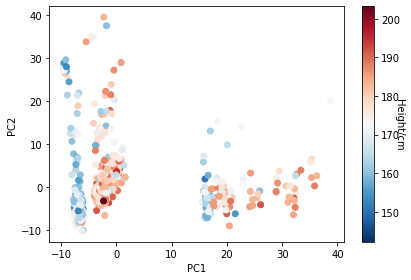

In [55]:
pcs = data.pca(x_train)
fig = plt.figure()

#ax.scatter3D(pcs[f_position,0],pcs[f_position,1],pcs[f_position,2],cmap='Greens',label='female')
#ax.scatter3D(pcs[m_position,0],pcs[m_position,1],pcs[m_position,2],cmap='Blues',label='male')
color_map = plt.get_cmap('RdBu_r')
scatter_plot =plt.scatter(pcs[:,0],pcs[:,1],c=ytrain,cmap = color_map)
plt.xlabel('PC1')
plt.ylabel('PC2')
#ax.set_zlabel('PC3',rotation=90)
#ax.set_clabel('Height')
cbar=plt.colorbar(scatter_plot)
cbar.set_label('Height/cm', rotation=270)
plt.tight_layout() 


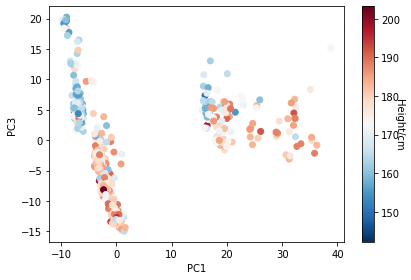

In [56]:
pcs = data.pca(x_train)
fig = plt.figure()

#ax.scatter3D(pcs[f_position,0],pcs[f_position,1],pcs[f_position,2],cmap='Greens',label='female')
#ax.scatter3D(pcs[m_position,0],pcs[m_position,1],pcs[m_position,2],cmap='Blues',label='male')
color_map = plt.get_cmap('RdBu_r')
scatter_plot =plt.scatter(pcs[:,0],pcs[:,2],c=ytrain,cmap = color_map)
plt.xlabel('PC1')
plt.ylabel('PC3')
#ax.set_zlabel('PC3',rotation=90)
#ax.set_clabel('Height')
cbar=plt.colorbar(scatter_plot)
cbar.set_label('Height/cm', rotation=270)
plt.tight_layout() 


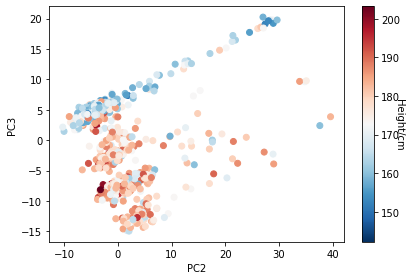

In [57]:
pcs = data.pca(x_train)
fig = plt.figure()

#ax.scatter3D(pcs[f_position,0],pcs[f_position,1],pcs[f_position,2],cmap='Greens',label='female')
#ax.scatter3D(pcs[m_position,0],pcs[m_position,1],pcs[m_position,2],cmap='Blues',label='male')
color_map = plt.get_cmap('RdBu_r')
scatter_plot =plt.scatter(pcs[:,1],pcs[:,2],c=ytrain,cmap = color_map)
plt.xlabel('PC2')
plt.ylabel('PC3')
#ax.set_zlabel('PC3',rotation=90)
#ax.set_clabel('Height')
cbar=plt.colorbar(scatter_plot)
cbar.set_label('Height/cm', rotation=270)
plt.tight_layout() 
